<a href="https://colab.research.google.com/github/SantanaC4/pos_tagging_treebank/blob/main/pos_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation Part of Speech Tagging from Treebank corpus using N-gram tecnique

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np
import seaborn as sn

!git clone https://github.com/wcipriano/pretty-print-confusion-matrix.git
!(cd pretty-print-confusion-matrix && mv confusion_matrix_pretty_print.py ../)
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

fatal: destination path 'pretty-print-confusion-matrix' already exists and is not an empty directory.
mv: cannot stat 'confusion_matrix_pretty_print.py': No such file or directory


## Some functions

In [103]:
##Upload Penn Treebank Corpus
# That function filter the pair (word, tag) of the data

def pair_filter(section):
  if (section == "training"):
    url = 'https://raw.githubusercontent.com/SantanaC4/pos_tagging_treebank/main/Sec0-18_training'
  if (section == "development"):
    url = 'https://raw.githubusercontent.com/SantanaC4/pos_tagging_treebank/main/Sec-19-21_development'
  if (section == "testing"):
    url = 'https://raw.githubusercontent.com/SantanaC4/pos_tagging_treebank/main/Sec-22-24_testing'

  df = pd.read_csv(url, header=None, sep='\n')
  spliting =  [i.split(" ") for i in df[0]]
  extracting_pair = []

  count = 0
  for i in spliting:
    if (len(i) == 1):
      if (i[0] != "''_''"):
          extracting_pair.append(tuple(i[0].split("_")))
    else:
      for j in i:
        if (j != "''_''" and j != "'_''"):
          extracting_pair.append(tuple(j.split("_")))
  return (extracting_pair)

## Function to sort tags probability
def sort_tags_probability(tags_frequency, word_frequency):
    result = []
    for (key, value) in tags_frequency.items():
      result.append((round(value/word_frequency, 2), key))
    return (sorted(result, reverse=True))

## Function to evaluating bigram model
def evaluating(model):
  tt = pair_filter("testing")
  aux = "<s>"

  accuracy = 0
  for (word, tag) in tt:
    if (model[aux + " " + word][0][1] == 'Unknown word'):
      if (model[aux + " " + '<UNK>'][0][1] == tag):
        accuracy += 1
    elif (model[aux + " " + word][0][1] == tag):
      accuracy += 1
    aux = tag

  return (accuracy/len(tt))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (17,17))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Unigram Tagger 
####Building a dictionary with probability of tags for each word based on the following equation.

$$
P(t_i|s_i) = \frac{C(t_i,s_i)}{C(s_i)}
$$
####This says that the emission probability of tag i given state i is the total number of times we observe state i emitting tag i divided by the total number of times we observe state i.

In [21]:
## Default dictionary 
## Assign default value to key that is not in dictionary
from collections import defaultdict

unigram = defaultdict(list)
for (word, tag) in pair_filter("training"):
  unigram[word].append(tag)

########################### This is optional#######################################
##########################Treatment for unknown words##############################
# Unknown words: replace the words whose frequency is lesser five for <UNK>
unigram_with_unk = defaultdict(list)
for i in unigram.items():
  if (len(i[1]) < 5):
    for j in i[1]:
      unigram_with_unk['<UNK>'].append(j)
  else:
    for j in i[1]:
      unigram_with_unk[i[0]].append(j)
  
count_unk_tags = defaultdict(int)
for i in unigram_with_unk['<UNK>']:
  count_unk_tags[i] += 1

max_key = max(count_unk_tags, key=count_unk_tags.get)
probability_of_unk_tag = count_unk_tags[max_key] / len(unigram_with_unk['<UNK>'])
tags_probability = defaultdict(lambda: [(probability_of_unk_tag ,max_key)])
unigram = unigram_with_unk

#################################################################################
#################################################################################


#### Warning ####
#### the line below should be uncommented out if the optional part above for commented
#### defaultdisct((lambda: [(0, 'NN')]) assign the 'NN' tag for unseend words in testing set
#### Warning ####

#tags_probability = defaultdict(lambda: [(0, 'NNP')])
word_freq = 0
aux = defaultdict(int)

for (word, tags) in unigram.items():
  word_freq = len(tags)
  for i in tags:
    aux[i] += 1
  tags_probability[word] = sorted([(value/word_freq, key) for (key, value) in aux.items()], reverse=True)
  aux = defaultdict(int)
  word_freq = 0

unigram_with_unk = tags_probability


print(unigram_with_unk['<UNK>'])
# unknown word
print(unigram_with_unk['asdfasdfasdfasdf'])
print(unigram_with_unk['is'])

[(0.25982905982905985, 'NNP'), (0.17251043530113297, 'NN'), (0.16189624329159213, 'JJ'), (0.11288014311270125, 'CD'), (0.10383621546412244, 'NNS'), (0.04184058835221626, 'VBG'), (0.031922083084873785, 'VBN'), (0.027807592923871995, 'VB'), (0.021904193997217252, 'RB'), (0.019618366129994038, 'VBD'), (0.01892267938779567, 'VBZ'), (0.009222818525144106, 'NNPS'), (0.0062413039157225205, 'VBP'), (0.0027429934406678594, 'JJR'), (0.0021864440469091632, 'JJS'), (0.0019479228781554363, 'FW'), (0.0015503875968992248, 'IN'), (0.0006758099781355595, 'UH'), (0.00035778175313059033, 'PRP'), (0.00033790498906777975, 'RBR'), (0.0003180282250049692, 'SYM'), (0.000278274696879348, 'WRB'), (0.0002385211687537269, 'MD'), (0.00019876764062810574, 'CC'), (0.00011926058437686345, 'DT'), (9.938382031405287e-05, 'LS'), (7.95070562512423e-05, 'WP'), (7.95070562512423e-05, 'WDT'), (7.95070562512423e-05, 'TO'), (5.9630292188431724e-05, 'RP'), (5.9630292188431724e-05, 'PDT'), (5.9630292188431724e-05, '$'), (3.9753

In [22]:
# Evaluating

tt = pair_filter("testing")
tt[0]
accuracy = 0
for (word, tag) in tt:
    if (tags_probability[word][0][1] == tag):
      accuracy += 1

accuracy/len(tt)

0.9001158550334736

Accuracy without group up words less frequenty:
0.9164082866706773 (92%)

Accuracy to '< UNK >' words. 0.9073474478924616 (90%)

##Bigram Tagger

In [23]:
###Using the previous word to compute the probability

def bigram_model(previous, with_unk=0):
  bigram = defaultdict(list)
  aux = "<s>"

  for (word, tag) in pair_filter("training"):
      bigram[aux + " " + word].append(tag)
      if (previous == "word"):
        aux = word
      elif (previous == "tag"):
        aux = tag
  
  tags_frequency = defaultdict(int)
  result = defaultdict(lambda: [(-1 ,'NNP')])

  #
  if (with_unk == 1):
    aux = "<s>"
    bigram_with_unk = defaultdict(list)
    for i in bigram.items():
      if (len(i[1]) < 5):
        for j in i[1]:
                bigram_with_unk[i[0].split(' ')[0] + " " + '<UNK>'].append(j)
      else:
        for j in i[1]:
                bigram_with_unk[i[0]].append(j)

    print("Quantidade de bigramas sem <UNK>: ", len(bigram.items()))
    print("Quantidade de bigramas com <UNK>: ", len(bigram_with_unk.items()))

    result = defaultdict(lambda: [(0, 'Unknown word')])
    bigram = bigram_with_unk
  #

  for (word, tags) in bigram.items():
    for i in tags:
      tags_frequency[i] += 1
    result[word] = sort_tags_probability(tags_frequency, len(tags))
    tags_frequency = defaultdict(int)
  return result

# Model without <UNK>
bigram_without_unk = bigram_model("tag")

# Model with <UNK>
bigram_with_unk = bigram_model("tag", 1)

Quantidade de bigramas sem <UNK>:  122034
Quantidade de bigramas com <UNK>:  20015


In [19]:
## Evaluating

print("Accuracy of bigram model without <UNK> technique: ", evaluating(bigram_without_unk))
print("Accuracy of bigram model with <UNK> technique: ", evaluating(bigram_with_unk))

Accuracy of bigram model without <UNK> technique:  0.9067639123233988
Accuracy of bigram model with <UNK> technique:  0.8594344097224922


##Trigram Tagger

In [90]:
def trigram_model(with_unk=0):
  trigram = defaultdict(list)
  aux = "<s>"
  aux2 = "<s>"

  for (word, tag) in pair_filter("training"):
      trigram[aux + " " + aux2 + " " + word].append(tag)
      aux = aux2
      aux2 = tag

  tags_frequency = defaultdict(int)
  result = defaultdict(lambda: [(0, "backoff")])
  for (word, tags) in trigram.items():
    for i in tags:
      tags_frequency[i] += 1
    result[word] = sort_tags_probability(tags_frequency, len(tags))
    tags_frequency = defaultdict(int)

  trigram = result
  return (trigram)

trigram = trigram_model("tag")

#### Evaluating trigram model with backoff technique
aux = "<s>"
aux2 = "<s>"
accuracy = 0

confusion_matrix = defaultdict(int)
for (word, tag) in pair_filter("testing"):
    if (trigram[aux + " " + aux2 + " " + word][0][1] == "backoff"):
        if (bigram_without_unk[aux2 + " " + word][0][1] == tag):
              accuracy += 1
              confusion_matrix[tag + " " + tag] += 1
        elif (bigram_without_unk[aux2 + " " + word][0][0] == -1):
          if (unigram_with_unk[word][0][1] == tag):
              accuracy += 1
              confusion_matrix[tag + " " + tag] += 1
          elif (unigram_with_unk[word][0][1] != tag):
              confusion_matrix[tag + " " + unigram_with_unk[word][0][1]] += 1
        elif (bigram_without_unk[aux2 + " " + word][0][0] != tag):
              confusion_matrix[tag + " " + bigram_without_unk[aux2 + " " + word][0][1]] += 1
    elif (trigram[aux + " " + aux2 + " " + word][0][1] == tag):
        accuracy += 1
        confusion_matrix[tag + " " + tag] += 1
    elif (trigram[aux + " " + aux2 + " " + word][0][1] != tag):
        confusion_matrix[tag + " " + trigram[aux + " " + aux2 + " " + word][0][1]] += 1
    
    aux = aux2
    aux2 = tag
print(confusion_matrix)

print("Trigram model accuracy using backoff technique: ", round(accuracy/len(tt)*100, 0),"%")

defaultdict(<class 'int'>, {'JJ NNP': 1132, 'NNS NNS': 7369, 'IN IN': 13079, 'DT DT': 11059, 'NNP NNP': 12760, 'NNP NNPS': 236, 'CC CC': 3230, 'VBD VBD': 4044, 'NN NN': 16365, 'WDT IN': 42, 'MD MD': 1265, 'VB VB': 3182, 'WRB WRB': 301, 'JJ JJ': 6512, ', ,': 6876, 'VBG VBG': 1547, 'TO TO': 2912, 'POS POS': 1264, '. .': 5381, 'WP$ WP$': 37, 'VBP VBP': 1391, '-LRB- -LRB-': 186, '-RRB- -RRB-': 187, 'WDT WDT': 536, 'RB RB': 3753, 'VBN VBN': 2167, 'VBZ VBZ': 2465, '`` ``': 1074, 'NN NNP': 967, 'RBR JJR': 79, 'JJ NN': 257, '$ $': 943, 'CD CD': 4176, 'VBP VB': 84, 'JJR JJR': 337, 'NN VBG': 122, 'RP RP': 273, 'PRP PRP': 2188, 'VBG NN': 106, 'VB NNP': 177, 'NN JJ': 225, 'VBN JJ': 91, 'VBN NNP': 192, 'IN RB': 144, 'DT IN': 79, 'VBG NNP': 261, 'VB VBP': 87, 'JJR RBR': 66, 'VBN VBD': 247, 'RB NNP': 140, ': :': 752, 'RP IN': 89, 'VBZ POS': 12, 'PRP$ PRP$': 1067, 'RBR RBR': 173, 'VBD NNP': 157, 'NN RB': 20, 'NN VBD': 6, 'VBD VBN': 329, 'JJ VBN': 113, 'PDT DT': 33, 'VBZ NNP': 91, 'NN VB': 79, 'RB IN':

/content/confusion_matrix_pretty_print.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/confusion_matrix_pretty_print.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/content/confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/confusion_matrix_pretty_print.py:169: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


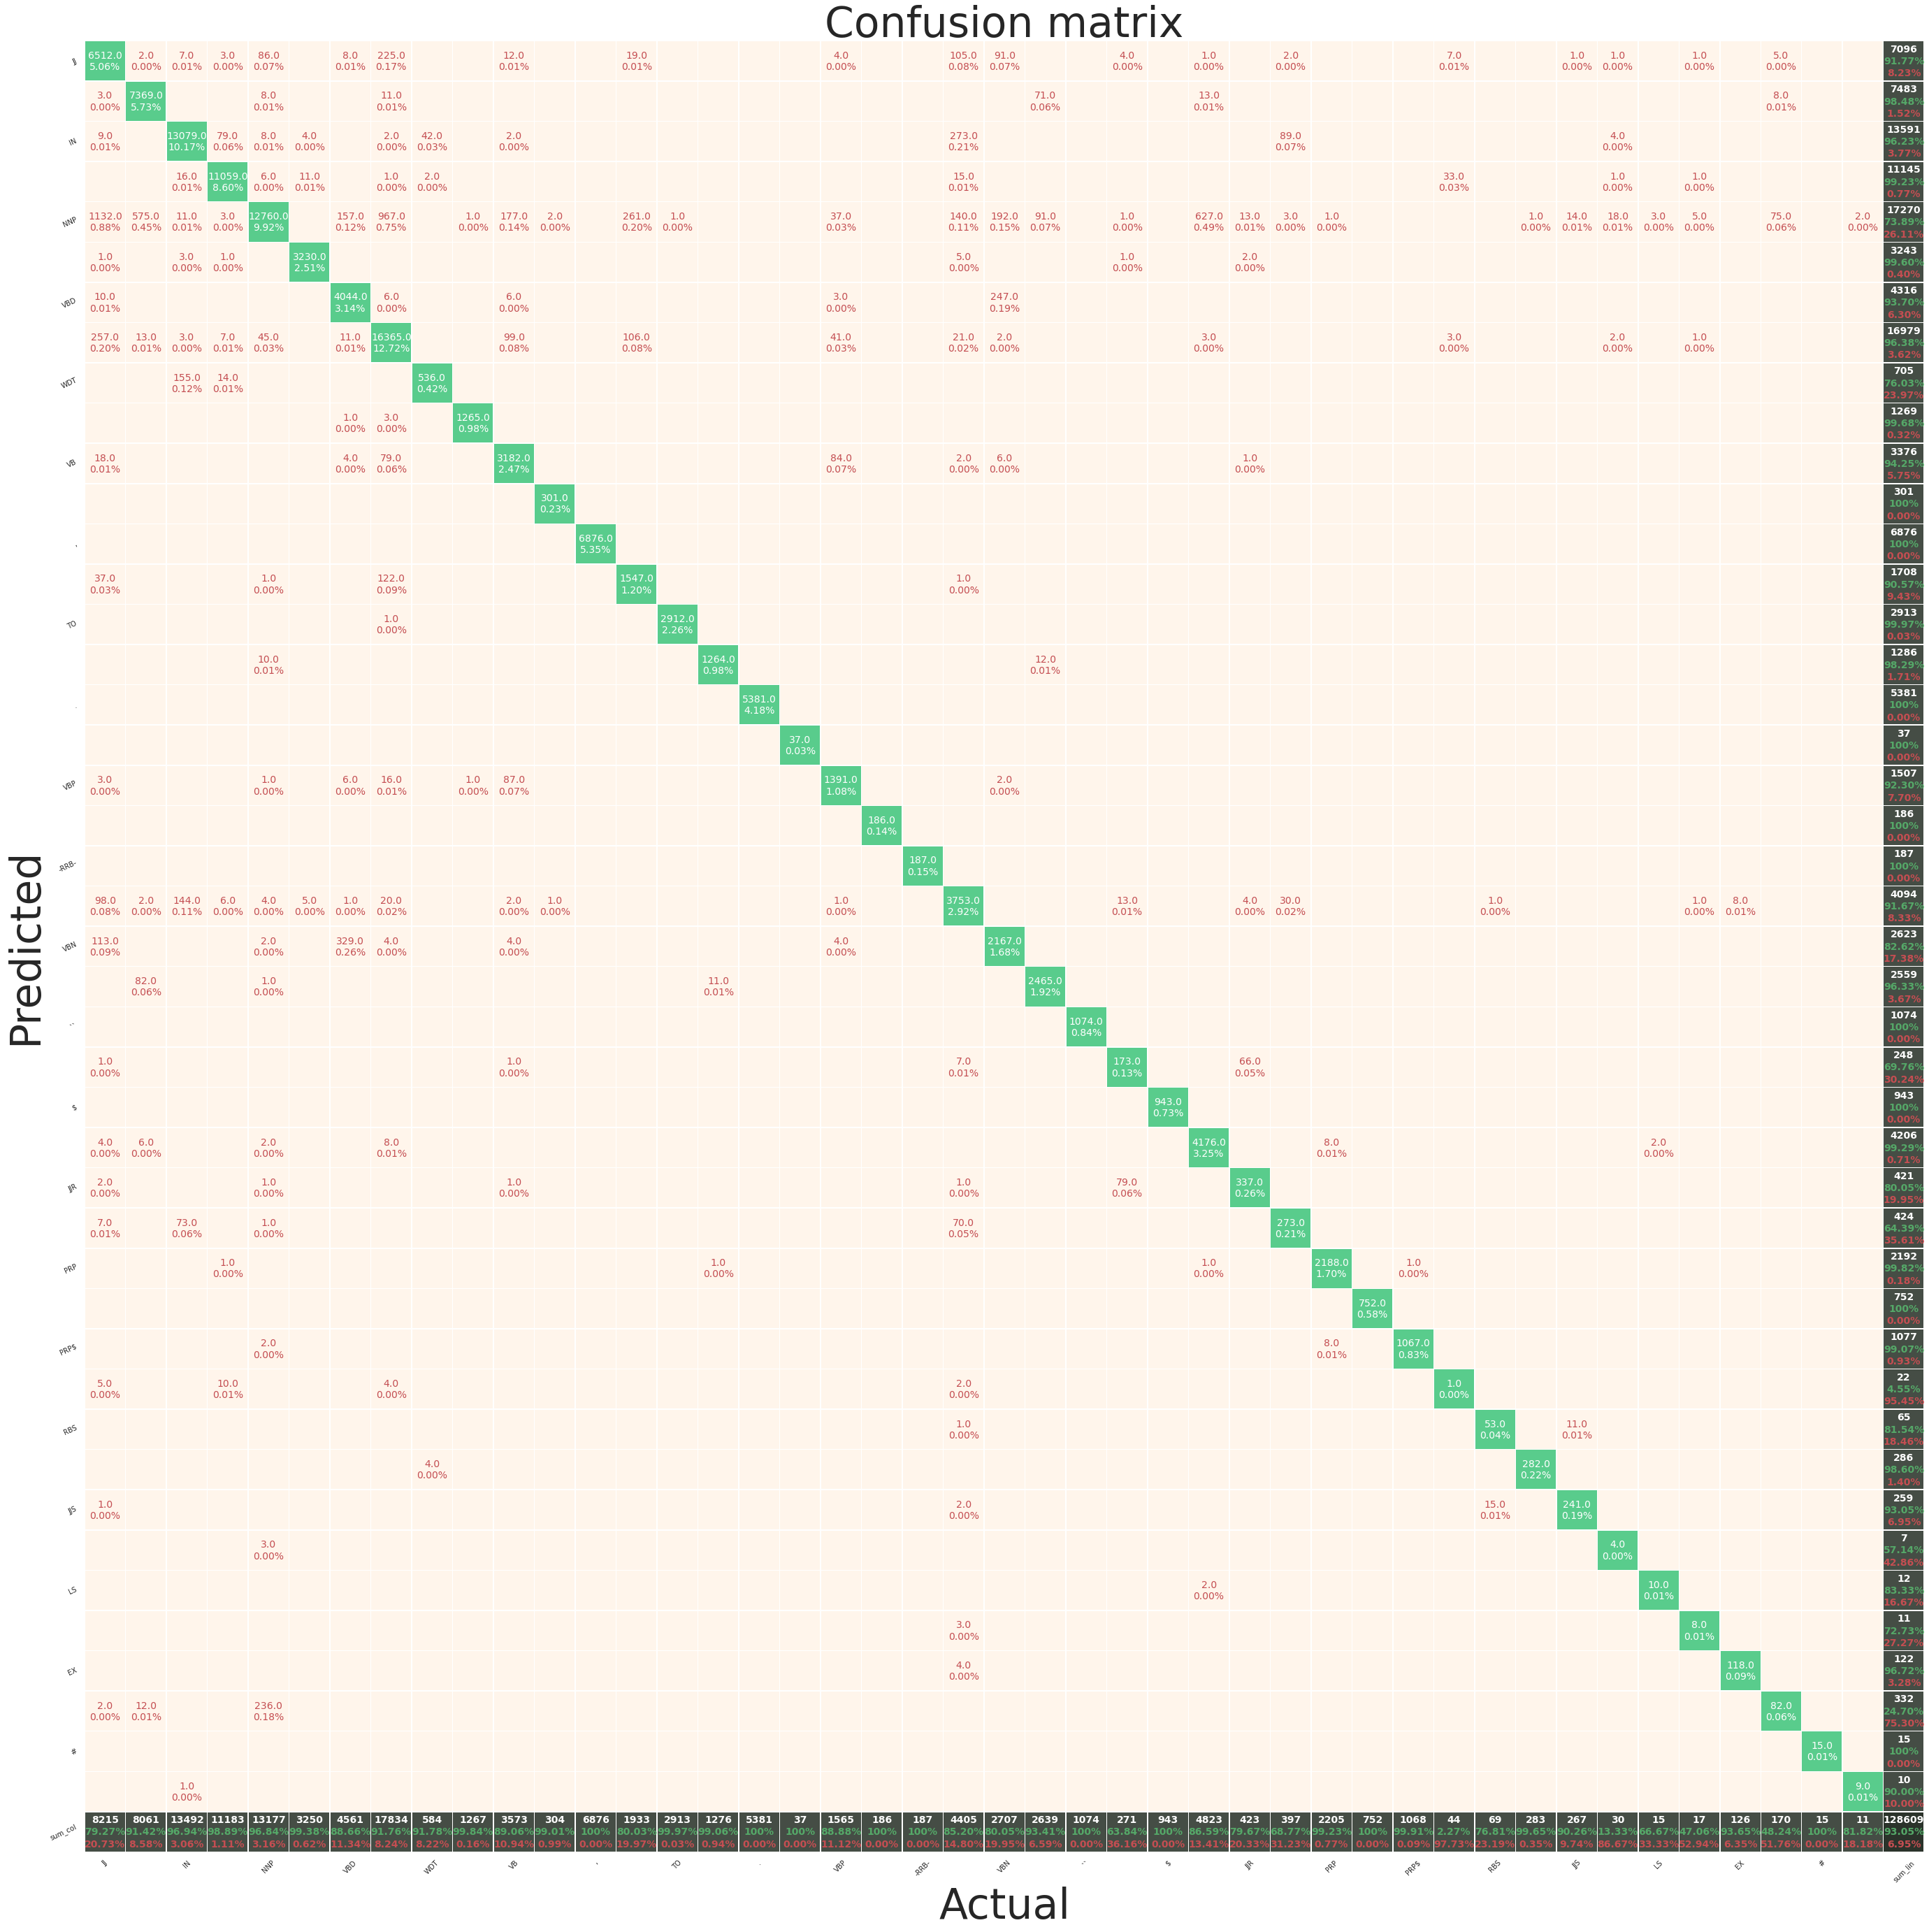

['JJ' 'NNS' 'IN' 'DT' 'NNP' 'CC' 'VBD' 'NN' 'WDT' 'MD' 'VB' 'WRB' ','
 'VBG' 'TO' 'POS' '.' 'WP$' 'VBP' '-LRB-' '-RRB-' 'RB' 'VBN' 'VBZ' '``'
 'RBR' '$' 'CD' 'JJR' 'RP' 'PRP' ':' 'PRP$' 'PDT' 'RBS' 'WP' 'JJS' 'FW'
 'LS' 'UH' 'EX' 'NNPS' '#' 'SYM']


In [132]:
## Confusion Matrix


classes = defaultdict(int)
for (word, tag) in pair_filter("testing"):
  classes[tag] += 1
classes = np.array([i for i in classes.keys()])
classes

cm = np.zeros((len(classes),len(classes)))
for tags,value in confusion_matrix.items():
  i = int(np.where(classes == (tags.split()[0]))[0])
  j = int(np.where(classes == (tags.split()[1]))[0])
  cm[i][j] = value

#plot_confusion_matrix(cm, classes)
df_cm = pd.DataFrame(cm, index = classes, columns = classes)

pretty_plot_confusion_matrix(df_cm, figsize=[40,40], fmt='.2f', fz=14)
print(classes)